***负面评论识别：先不用word2vec，及doc2vec提取特征


In [1]:
#导入相关的包
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_1d, global_max_pool
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.neural_network import MLPClassifier
from tflearn.layers.normalization import local_response_normalization
from tensorflow.contrib import learn

#给定特征的最大个数,以及文档的长度
"""
把下面这两个参数调小一点，便于在自己的电脑上运行
"""
max_features=200
max_document_length=500  #词汇表模型中需要用到,这个参数的取值会影响到cnn模型的正常运行(out of list)
vocabulary=None

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-09 18:43:00
Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


D:\anaconda3_5\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


end_time: 2021-11-09 18:43:33


In [2]:
"""
读取文件数据,看起来像是将一个文档(文件)加载到一个字符串,然后再保存到列表中。
"""
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

def load_one_file(filename):
    x=""
    with open(filename,encoding='gb18030', errors='ignore') as f:
        for line in f:
            line=line.strip('\n')
            line = line.strip('\r')
            x+=line
    f.close()
    return x

def load_files_from_dir(rootdir):
    x=[]
    list = os.listdir(rootdir)
    for i in range(0, len(list)):
        path = os.path.join(rootdir, list[i])
        if os.path.isfile(path):
            v=load_one_file(path)
            x.append(v)
    return x

def load_all_files():
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    path="E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/"
    print ("Load %s" % path)
    x_train=load_files_from_dir(path)
    y_train=[0]*len(x_train)
    path="E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/"
    print ("Load %s" % path)
    tmp=load_files_from_dir(path)
    y_train+=[1]*len(tmp)
    x_train+=tmp

    path="E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/"
    print ("Load %s" % path)
    x_test=load_files_from_dir(path)
    y_test=[0]*len(x_test)
    path="E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/"
    print ("Load %s" % path)
    tmp=load_files_from_dir(path)
    y_test+=[1]*len(tmp)
    x_test+=tmp

    return x_train, x_test, y_train, y_test

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-09 18:43:33
end_time: 2021-11-09 18:43:33


In [4]:
"""
一:特征提取：1，词袋模型
"""
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

def get_features_by_wordbag():
    global max_features
    x_train, x_test, y_train, y_test=load_all_files()

    vectorizer = CountVectorizer(
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    print (vectorizer)
    x_train=vectorizer.fit_transform(x_train)
    x_train=x_train.toarray()
    vocabulary=vectorizer.vocabulary_
    
    #用训练集生成的词袋模型对测试数据进行词袋化处理
    vectorizer = CountVectorizer(
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 vocabulary=vocabulary,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    print (vectorizer)
    x_test=vectorizer.fit_transform(x_test)
    x_test=x_test.toarray()

    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = get_features_by_wordbag()
x_train
x_train.shape
#(25000,300)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(decode_error='ignore', max_features=200, stop_words='english',
                strip_accents='ascii')
CountVectorizer(decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'10': 0, 'acting': 1, 'action': 2, 'actor': 3,
                            'actors': 4, 'actually': 5, 'american': 6,
                            'audience': 7, 'away': 8, 'awful': 9, 'bad': 10,
                            'beautiful': 11, 'believe': 12, 'best': 13,
                            'better': 14, 'big': 15, 'bit': 16, 'black': 17,
                            'book': 18, 'boring': 19, 'br': 20, 'budget': 21,
                            'camera': 22, 'cast': 23, 

(25000, 200)

In [3]:
"""
一:特征提取：2，TF-IDF模型
"""
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

def get_features_by_wordbag_tfidf():
    global max_features
    x_train, x_test, y_train, y_test=load_all_files()

    vectorizer = CountVectorizer(
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1,
                                 binary=True)
    print (vectorizer)
    x_train=vectorizer.fit_transform(x_train)
    x_train=x_train.toarray()
    vocabulary=vectorizer.vocabulary_
   #用训练集生成的词袋模型对测试数据进行词袋化处理
    vectorizer = CountVectorizer(
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 vocabulary=vocabulary,
                                 stop_words='english',
                                 max_df=1.0,binary=True,
                                 min_df=1 )
    print (vectorizer)
    x_test=vectorizer.fit_transform(x_test)
    x_test=x_test.toarray()

    transformer = TfidfTransformer(smooth_idf=False)
    x_train=transformer.fit_transform(x_train)
    x_train=x_train.toarray()
    x_test=transformer.transform(x_test)
    x_test=x_test.toarray()

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_features_by_wordbag_tfidf()
x_train
x_train.shape

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-07 15:00:23
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(binary=True, decode_error='ignore', max_features=200,
                stop_words='english', strip_accents='ascii')
CountVectorizer(binary=True, decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'10': 0, 'acting': 1, 'action': 2, 'actor': 3,
                            'actors': 4, 'actually': 5, 'american': 6,
                            'audience': 7, 'away': 8, 'bad': 9, 'beautiful': 10,
                            'believe': 11, 'best': 12, 'better': 13, 'big': 14,
                            'bit': 15, 'black': 16, 'boring': 17, 'br': 18,
                            'budget': 19, 'came': 20, 'camera':

In [3]:
"""
一:特征提取：3，词汇表模型，
"""
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

def  get_features_by_tf():
    global  max_document_length
    x_train, x_test, y_train, y_test=load_all_files()

    vp=tflearn.data_utils.VocabularyProcessor(max_document_length=max_document_length,
                                              min_frequency=0,
                                              vocabulary=None,
                                              tokenizer_fn=None)
    x_train=vp.fit_transform(x_train, unused_y=None)
    x_train=np.array(list(x_train))

    x_test=vp.transform(x_test)
    x_test=np.array(list(x_test))
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_features_by_tf()
x_train
x_train.shape

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-09 00:08:11
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
end_time: 2021-11-09 00:10:56


In [5]:
"""
二：定义训练模型:
"""
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))
#通过贝叶斯模型的效果来对特征的个数做决定。
def show_diffrent_max_features():
    global max_features
    a=[]
    b=[]
    for i in range(1000,20000,2000):
        max_features=i
        print ("max_features=%d" % i)
        #x, y = get_features_by_wordbag()
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
        x_train, x_test, y_train, y_test=get_features_by_wordbag()
        gnb = GaussianNB()
        gnb.fit(x_train, y_train)
        y_pred = gnb.predict(x_test)
        score=metrics.accuracy_score(y_test, y_pred)
        a.append(max_features)
        b.append(score)
        plt.plot(a, b, 'r')
    plt.xlabel("max_features")
    plt.ylabel("metrics.accuracy_score")
    plt.title("metrics.accuracy_score VS max_features")
    plt.legend()
    plt.show()

#贝叶斯模型
def do_nb_wordbag(x_train, x_test, y_train, y_test):
    #print ("NB and wordbag")
    gnb = GaussianNB()
    gnb.fit(x_train,y_train)
    y_pred=gnb.predict(x_test)
    print (metrics.accuracy_score(y_test, y_pred))
    print (metrics.confusion_matrix(y_test, y_pred))
    
#支持向量机
def do_svm_wordbag(x_train, x_test, y_train, y_test):
    #print ("SVM and wordbag")
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print (metrics.accuracy_score(y_test, y_pred))
    print (metrics.confusion_matrix(y_test, y_pred))

    
#词袋模型-卷积神经网络
def do_cnn_wordbag(trainX, testX, trainY, testY):
    global max_document_length
    #print ("CNN and tf")

    trainX = pad_sequences(trainX, maxlen=max_document_length, value=0.) #对数据进行填充，不带最大长度的用0替换
    testX = pad_sequences(testX, maxlen=max_document_length, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Building convolutional network(change output_dim = 64 --> output_dim = 32,n_epoch= 5 --> n_epoch =1)
    network = input_data(shape=[None,max_document_length], name='input')
    network = tflearn.embedding(network, input_dim=10240000, output_dim=32)
    branch1 = conv_1d(network, 32, 3, padding='valid', activation='relu', regularizer="L2")
    branch2 = conv_1d(network, 32, 4, padding='valid', activation='relu', regularizer="L2")
    branch3 = conv_1d(network, 32, 5, padding='valid', activation='relu', regularizer="L2")
    network = merge([branch1, branch2, branch3], mode='concat', axis=1)
    network = tf.expand_dims(network, 2)
    network = global_max_pool(network)
    network = dropout(network, 0.8)
    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target')
    # Training
    model = tflearn.DNN(network, tensorboard_verbose=0)
    model.fit(trainX, trainY,
              n_epoch=1, shuffle=True, validation_set=(testX, testY),
              show_metric=True, batch_size=100,run_id="review")

    
#词袋模型-rnn循环神经网络,output_dim =128 -->output_dim = 32,n_epoch=1
def do_rnn_wordbag(trainX, testX, trainY, testY):
    global max_document_length
    #print ("RNN and wordbag")

    trainX = pad_sequences(trainX, maxlen=max_document_length, value=0.)
    testX = pad_sequences(testX, maxlen=max_document_length, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Network building
    net = tflearn.input_data([None, max_document_length])
    net = tflearn.embedding(net, input_dim=10240000, output_dim=32)
    net = tflearn.lstm(net, 32, dropout=0.8)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                             loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)
    model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
              batch_size=10,run_id="review",n_epoch=1)

#词袋模型-多层感知机模型   
def do_dnn_wordbag(x_train, x_test, y_train, y_test):
    #print ("MLP and wordbag")

    # Building deep neural network
    clf = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        hidden_layer_sizes = (5, 2),
                        random_state = 1)
    print  (clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print (metrics.accuracy_score(y_test, y_pred))
    print (metrics.confusion_matrix(y_test, y_pred))

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-09 18:57:50
end_time: 2021-11-09 18:57:50


In [ ]:
"""
第三大部分：开始进行模型训练

"""

max_features=1000
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(decode_error='ignore', max_features=1000, stop_words='english',
                strip_accents='ascii')
CountVectorizer(decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'10': 0, '100': 1, '15': 2, '20': 3, '30': 4,
                            '50': 5, '80': 6, '90': 7, 'ability': 8, 'able': 9,
                            'absolutely': 10, 'accent': 11, 'act': 12,
                            'acted': 13, 'acting': 14, 'action': 15,
                            'actor': 16, 'actors': 17, 'actress': 18,
                            'actual': 19, 'actually': 20, 'add': 21,
                            'admit': 22, 'adult': 23

max_features=17000
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(decode_error='ignore', max_features=17000, stop_words='english',
                strip_accents='ascii')
CountVectorizer(decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'00': 0, '000': 1, '007': 2, '01': 3, '02': 4,
                            '05': 5, '06': 6, '10': 7, '100': 8, '1000': 9,
                            '101': 10, '102': 11, '10th': 12, '11': 13,
                            '110': 14, '11th': 15, '12': 16, '120': 17,
                            '12th': 18, '13': 19, '13th': 20, '14': 21,
                            '140': 22, '14th': 23, '15': 24, '150': 25,
                            '16': 26, '16mm'

No handles with labels found to put in legend.


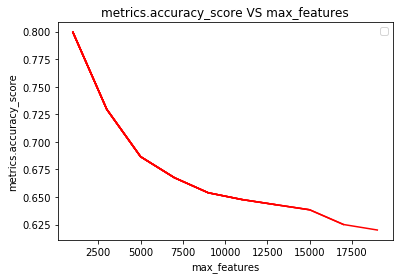

In [8]:
#通过贝叶斯模型的效果来对特征的个数做决定。
"""
选定超参数的个数,
"""
show_diffrent_max_features()

In [10]:
"""
三：模型训练
   --词袋模型1
   --max_feaure = 300
   --max_document_length = 500
   
因为有将文档的最大长度减少，所以看到准确率是由稍微降低的
"""
max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))


print ("start get_features_by_wordbag --->")
x_train, x_test, y_train, y_test=get_features_by_wordbag()

#Nb
print("start NB")
do_nb_wordbag(x_train, x_test, y_train, y_test)

#SVM
print("start SVM")
do_svm_wordbag(x_train, x_test, y_train, y_test)

#多层感知机。
print("start DNN")
do_dnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-07 11:12:16
start get_features_by_wordbag --->
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(decode_error='ignore', max_features=200, stop_words='english',
                strip_accents='ascii')
CountVectorizer(decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'10': 0, 'acting': 1, 'action': 2, 'actor': 3,
                            'actors': 4, 'actually': 5, 'american': 6,
                            'audience': 7, 'away': 8, 'awful': 9, 'bad': 10,
                            'beautiful': 11, 'believe': 12, 'best': 13,
                            'better': 14, 'big': 15, 'bit': 16, 'black': 17,
                            'book': 18, 'boring': 19, 'br': 20, '

D:\anaconda3_5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [11]:
"""
三：模型训练
   --词袋模型2
   --max_feaure = 300
   --max_document_length = 500
"""
"""
*从结果来看，CNN在词袋模型上效果表现不好
*内存不够，不支持RNN模型训练，且词袋模型特征,不适合RNN,RNN适合处理有时序关系的序列。
"""
max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))


print ("start get_features_by_wordbag --->")
x_train, x_test, y_train, y_test=get_features_by_wordbag()
#卷积神经网络。
print("start CNN")
do_cnn_wordbag(x_train, x_test, y_train, y_test)


print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 249  | total loss: 0.69318 | time: 6375.002s
| Adam | epoch: 001 | loss: 0.69318 - acc: 0.5079 -- iter: 24900/25000
Training Step: 250  | total loss: 0.69319 | time: 6416.163s
| Adam | epoch: 001 | loss: 0.69319 - acc: 0.5062 | val_loss: 0.69314 - val_acc: 0.5000 -- iter: 25000/25000
--
end_time: 2021-11-07 13:07:33


In [5]:
"""
三：模型训练
   --TF-IDF模型1
"""
"""
这里的DNN模型分类这么差
max_feature = 200
"""
max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))


print ("start get_features_by_wordbag_tfidf --->")
x_train, x_test, y_train, y_test=get_features_by_wordbag_tfidf()

#Nb
print("start NB")
do_nb_wordbag(x_train, x_test, y_train, y_test)

#SVM
print("start SVM")
do_svm_wordbag(x_train, x_test, y_train, y_test)

#多层感知机。
print("start DNN")#这里的结果很奇怪
do_dnn_wordbag(x_train, x_test, y_train, y_test)


print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-07 15:10:24
start get_features_by_wordbag_tfidf --->
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
CountVectorizer(binary=True, decode_error='ignore', max_features=200,
                stop_words='english', strip_accents='ascii')
CountVectorizer(binary=True, decode_error='ignore', stop_words='english',
                strip_accents='ascii',
                vocabulary={'10': 0, 'acting': 1, 'action': 2, 'actor': 3,
                            'actors': 4, 'actually': 5, 'american': 6,
                            'audience': 7, 'away': 8, 'bad': 9, 'beautiful': 10,
                            'believe': 11, 'best': 12, 'better': 13, 'big': 14,
                            'bit': 15, 'black': 16, 'boring': 17, 'br': 18,
                      

In [6]:
"""
三：模型训练
   --TF-IDf模型2
"""
"""
有的时候会出现报错
"""

max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tfidf --->")
x_train, x_test, y_train, y_test=get_features_by_wordbag_tfidf()

#卷积神经网络。
print("start CNN")
do_cnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 249  | total loss: 0.69341 | time: 1349.115s
| Adam | epoch: 001 | loss: 0.69341 - acc: 0.4904 -- iter: 24900/25000
Training Step: 250  | total loss: 0.69344 | time: 1358.802s
| Adam | epoch: 001 | loss: 0.69344 - acc: 0.4883 | val_loss: 0.69318 - val_acc: 0.5000 -- iter: 25000/25000
--
end_time: 2021-11-07 15:38:02


In [9]:
"""
三：模型训练
   --TF(词汇表)模型1
"""
"""
max_feature = 200
max_document_length = 500
--可以试试RNN模型
"""
max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))


print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#Nb
print("start NB")
do_nb_wordbag(x_train, x_test, y_train, y_test)

#SVM
print("start SVM")
do_svm_wordbag(x_train, x_test, y_train, y_test)

#多层感知机。
print("start DNN")#这里的结果很奇怪
do_dnn_wordbag(x_train, x_test, y_train, y_test)


print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-07 15:52:41
start get_features_by_wordbag_tf --->
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
start NB
0.5054
[[9994 2506]
 [9859 2641]]
start SVM
0.53244
[[8831 3669]
 [8020 4480]]
start DNN
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
0.49992
[[    4 12496]
 [    6 12494]]
end_time: 2021-11-07 15:59:24


In [5]:
"""
三：模型训练
   --TF(词汇表)模型2
"""
"""
词汇表模型在CNN中准确率提高
"""

max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#卷积神经网络。
print("start CNN")
do_cnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 249  | total loss: 0.45247 | time: 1075.724s
| Adam | epoch: 001 | loss: 0.45247 - acc: 0.7988 -- iter: 24900/25000
Training Step: 250  | total loss: 0.45441 | time: 1088.822s
| Adam | epoch: 001 | loss: 0.45441 - acc: 0.7999 | val_loss: 0.45172 - val_acc: 0.7915 -- iter: 25000/25000
--
end_time: 2021-11-07 17:54:18


In [5]:
"""
三：模型训练
   --TF(词汇表)模型2
"""RNN
"""
词汇表模型在RNN中准确率提高
"""

max_features=200
max_document_length=20 
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#卷积神经网络。
print("start RNN")
do_rnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 2499  | total loss: 0.44266 | time: 9313.435s
| Adam | epoch: 001 | loss: 0.44266 - acc: 0.7940 -- iter: 24990/25000
Training Step: 2500  | total loss: 0.41783 | time: 9321.477s
| Adam | epoch: 001 | loss: 0.41783 - acc: 0.8146 | val_loss: 0.58620 - val_acc: 0.6940 -- iter: 25000/25000
--
end_time: 2021-11-08 00:53:29


In [5]:
"""
三：模型训练
   --TF(词汇表)模型2
"""
"""
词汇表模型在RNN中准确率提高
"""

max_features=200
max_document_length=50
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#卷积神经网络。
print("start RNN")
do_rnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 2499  | total loss: 0.29760 | time: 9464.104s
| Adam | epoch: 001 | loss: 0.29760 - acc: 0.9001 -- iter: 24990/25000
Training Step: 2500  | total loss: 0.29589 | time: 9477.273s
| Adam | epoch: 001 | loss: 0.29589 - acc: 0.9001 | val_loss: 0.51490 - val_acc: 0.7622 -- iter: 25000/25000
--
end_time: 2021-11-08 12:10:00


In [5]:
"""
三：模型训练
   --TF(词汇表)模型2
"""
"""
词汇表模型在RNN中准确率提高
"""

max_features=200
max_document_length=100
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#卷积神经网络。
print("start RNN")
do_rnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 2499  | total loss: 0.32142 | time: 10755.006s
| Adam | epoch: 001 | loss: 0.32142 - acc: 0.8877 -- iter: 24990/25000
Training Step: 2500  | total loss: 0.33232 | time: 10772.556s
| Adam | epoch: 001 | loss: 0.33232 - acc: 0.8789 | val_loss: 0.45650 - val_acc: 0.7992 -- iter: 25000/25000
--
end_time: 2021-11-08 15:28:53


In [5]:
"""
三：模型训练
   --TF(词汇表)模型2
"""
"""
词汇表模型在RNN中准确率提高
"""

max_features=200
max_document_length=500
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))



print ("start get_features_by_wordbag_tf --->")
x_train, x_test, y_train, y_test=get_features_by_tf()

#卷积神经网络。
print("start RNN")
do_rnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 2499  | total loss: 0.69299 | time: 9632.946s
| Adam | epoch: 001 | loss: 0.69299 - acc: 0.5219 -- iter: 24990/25000
Training Step: 2500  | total loss: 0.69220 | time: 9697.120s
| Adam | epoch: 001 | loss: 0.69220 - acc: 0.5597 | val_loss: 0.69294 - val_acc: 0.5058 -- iter: 25000/25000
--
end_time: 2021-11-09 02:54:58


In [3]:
"""
补充：
通过TF-IDF提取文本特征的第二种方法(新)
直接通过TF-IDF模型构建文本特征
"""
import pandas as pd
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))
from sklearn.feature_extraction.text import TfidfVectorizer
def get_features_by_tfidf():
    x_train, x_test, y_train, y_test=load_all_files()
    #all_text = pd.concat([pd.DataFrame(x_train), pd.DataFrame(x_test)])
    all_text = x_train + x_test
    
    word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'-?\w{1,}', #通过-?来考虑正负号的顺序
    stop_words='english',
    ngram_range=(1, 1),
    max_features=200)
    
    word_vectorizer.fit(all_text)
    x_train = word_vectorizer.transform(x_train).toarray()
    x_test = word_vectorizer.transform(x_test).toarray() 
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_features_by_tfidf()
print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))
x_train
#shape(2500,200)

start_time: 2021-11-09 18:43:33
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
end_time: 2021-11-09 18:51:52


array([[0.        , 0.        , 0.        , ..., 0.        , 0.20512178,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11070832,
        0.1216088 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
"""
三：模型训练
   --TF-IDF(新)模型2
"""
"""
max_feature = 200
max_document_length = 500
"""
max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

print ("start get_features_by_tfidf(new kind of tf-idf)--->")
x_train, x_test, y_train, y_test=get_features_by_tfidf()

#Nb
print("start NB")
do_nb_wordbag(x_train, x_test, y_train, y_test)

#SVM
print("start SVM")
do_svm_wordbag(x_train, x_test, y_train, y_test)

#多层感知机。
print("start DNN")#这里的结果很奇怪
do_dnn_wordbag(x_train, x_test, y_train, y_test)


print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

start_time: 2021-11-09 16:02:00
start get_features_by_tfidf(new kind of tf-idf)--->
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/train/neg/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/pos/
Load E:/pycharm_project/deep_learning_web_safe/review/data/test/neg/
start NB
0.76276
[[9641 2859]
 [3072 9428]]
start SVM
0.79096
[[10024  2476]
 [ 2750  9750]]
start DNN
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
0.5
[[12500     0]
 [12500     0]]
end_time: 2021-11-09 16:05:50


In [6]:
"""
三：模型训练
   --TF-IDF(新)模型2
"""
"""
CNN模型训练
"""

max_features=200
max_document_length=500  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

print ("start get_features_by_tfidf(new kind of tf-idf)--->")
x_train, x_test, y_train, y_test=get_features_by_tfidf()

#卷积神经网络。
print("start CNN")
do_cnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 249  | total loss: 0.69309 | time: 1307.355s
| Adam | epoch: 001 | loss: 0.69309 - acc: 0.5108 -- iter: 24900/25000
Training Step: 250  | total loss: 0.69310 | time: 1321.471s
| Adam | epoch: 001 | loss: 0.69310 - acc: 0.5097 | val_loss: 0.69316 - val_acc: 0.5000 -- iter: 25000/25000
--
end_time: 2021-11-09 16:53:40


In [6]:
"""
三：模型训练
   --TF-IDF(新) 模型2
"""
"""
RNN模型训练
"""

max_features=200
max_document_length=50  
vocabulary=None
import datetime
print('start_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

print ("start get_features_by_tfidf(new kind of tf-idf)--->")
x_train, x_test, y_train, y_test=get_features_by_tfidf()

#卷积神经网络。
print("start RNN")
do_rnn_wordbag(x_train, x_test, y_train, y_test)

print('end_time: ' + datetime.datetime.strftime(datetime.datetime.now(),'%Y-%m-%d %H:%M:%S'))

Training Step: 2499  | total loss: 0.69504 | time: 15527.173s
| Adam | epoch: 001 | loss: 0.69504 - acc: 0.4795 -- iter: 24990/25000
Training Step: 2500  | total loss: 0.69472 | time: 15540.990s
| Adam | epoch: 001 | loss: 0.69472 - acc: 0.4916 | val_loss: 0.69341 - val_acc: 0.5000 -- iter: 25000/25000
--
end_time: 2021-11-09 23:19:52
